# Team Project

In [39]:
# libraries to import
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpltlib
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sns.set(style="darkgrid")
%matplotlib inline

In [40]:
## read datas

# geographic data
tor_map = "Neighbourhoods.shp"
regions = gpd.read_file(tor_map)

# crime data
crime_raw = pd.read_csv("Neighbourhood_Crime_Rates.csv")

# neighbourhood data
neighbourhood_raw = pd.read_csv("neighbourhood-profiles-2016-140-model.csv")


In [41]:
%%capture --no-display
regions['neighbourhood'] = regions['FIELD_7'].str.replace(' \(.+\)', '')

# keep coordinates, polygons, and neighbourhood name
regions_cleaned = regions[['FIELD_11', 'FIELD_12', 'geometry', 'neighbourhood']]
regions_cleaned = regions_cleaned.rename(columns={'FIELD_11':'longitute', 'FIELD_12':'latitude'})


In [42]:
# keep relevant variables for analysis. since the other csv contains data from 2016, only focus on 2016 data
crime_2016 = crime_raw[['Neighbourhood', 'Assault_2016', 'Assault_Rate2016', 'AutoTheft_2016', 'AutoTheft_Rate2016',
                      'BreakAndEnter_2016', 'BreakAndEnter_Rate2016', 'Robbery_2016', 'Robbery_Rate2016',
                      'TheftOver_2016', 'TheftOver_Rate2016', 'Homicide_2016', 'Homicide_Rate2016',
                      'Shootings_2016', 'Shootings_Rate2016']]

In [43]:
# join crime data and heat map data
crime_regions = regions_cleaned.set_index('neighbourhood').join(crime_2016.set_index('Neighbourhood'))
crime_regions = crime_regions.reset_index()
crime_regions = crime_regions.fillna(0)

# create a total crimes
crime_regions['TotalCrimes_2016'] = crime_regions['Assault_2016']+ \
                            crime_regions['AutoTheft_2016']+ \
                            crime_regions['BreakAndEnter_2016']+ \
                            crime_regions['Robbery_2016']+ \
                            crime_regions['TheftOver_2016']+ \
                            crime_regions['Homicide_2016']+ \
                            crime_regions['Shootings_2016']
crime_regions['TotalCrimes_Rate2016'] = crime_regions['Assault_Rate2016']+ \
                            crime_regions['AutoTheft_Rate2016']+ \
                            crime_regions['BreakAndEnter_Rate2016']+ \
                            crime_regions['Robbery_Rate2016']+ \
                            crime_regions['TheftOver_Rate2016']+ \
                            crime_regions['Homicide_Rate2016']+ \
                            crime_regions['Shootings_Rate2016']


# create "property" type crimes variable
crime_regions['PropertyCrimes_2016'] = crime_regions['AutoTheft_2016'] + crime_regions['BreakAndEnter_2016'] + crime_regions['Robbery_2016'] + crime_regions['TheftOver_2016']
crime_regions['PropertyCrimes_Rate2016'] = crime_regions['AutoTheft_Rate2016'] + crime_regions['BreakAndEnter_Rate2016'] + crime_regions['Robbery_Rate2016'] + crime_regions['TheftOver_Rate2016']
# create "violence" type crimes variable
crime_regions['ViolenceCrimes_2016'] = crime_regions['Assault_Rate2016'] + crime_regions['Homicide_Rate2016']+ crime_regions['Shootings_Rate2016']
crime_regions['ViolenceCrimes_Rate2016'] = crime_regions['Assault_Rate2016'] + crime_regions['Homicide_Rate2016']+ crime_regions['Shootings_Rate2016']

In [44]:
# Unpivot the neighbourhood dataframe
neighbourhood = pd.melt(neighbourhood_raw, id_vars=['Category','Topic','Data Source','Characteristic'])

In [45]:
# cleaning neighbourhood
# remove rows that are not neighbourhood

# remove rows with variable = '_id'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == '_id'].index
)

# remove rows with variable = 'City of Toronto'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == 'City of Toronto'].index
)

# now in the neighbourhood we have only neighbourhood

In [46]:
# adjust column names
neighbourhood = neighbourhood.rename(columns={'Category': 'category', 'Topic': 'topic', 'Data Source': 'data_source', 'Characteristic':'characteristic', 'variable': 'neighbourhood'})


In [47]:
# function to return a dataframe filtering values from neighbourhood dataframme
def neighbourhoodDataframeValueFiltered(column, filter):
    newDataframe = neighbourhood[['characteristic','neighbourhood','value']].query('characteristic == "'+filter+'"')
    
    # adjust column name
    newDataframe = newDataframe.rename(columns={'value': column})

    # adjust type of column to int
    newDataframe[column] = newDataframe[column].str.replace(',', '')
    newDataframe = newDataframe.astype({column: float})
    newDataframe = newDataframe.drop('characteristic', axis=1)
    
    # return dataFrame 
    return newDataframe

In [48]:
# dictionary with column name and condition to add from neighbourhood to crime_regions
dict_columns = {}
dict_columns['population'] = 'Population, 2016'
dict_columns['children'] = 'Children (0-14 years)'
dict_columns['youth']='Youth (15-24 years)'
dict_columns['workingAge']='Working Age (25-54 years)'
dict_columns['preRetirement']='Pre-retirement (55-64 years)'
dict_columns['seniors']='Seniors (65+ years)'
dict_columns['olderSeniors']='Older Seniors (85+ years)'
dict_columns['seniors_alone']='Persons age 65+ living alone (total)'
dict_columns['income']='Total income: Average amount ($)'
dict_columns['education']='Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data'
dict_columns['indigenous']='Total - Aboriginal identity for the population in private households - 25% sample data'
dict_columns['unemployment']='Employment rate'


In [49]:
# loop to add columns (definied in dictionary) to crime_regions
for column in dict_columns:
    crime_regions = crime_regions.merge(neighbourhoodDataframeValueFiltered(column, dict_columns[column]), left_on='neighbourhood', right_on='neighbourhood')


In [50]:
# convert variables to per capita measures (per 100000 people)
population_variables = ['children', 'youth', 'workingAge', 'preRetirement', 'seniors', 'olderSeniors', 'seniors_alone', 'education', 'indigenous']
# this should work but isn't generating the right numbers
# crime_regions[population_variables_colnames] = crime_regions.apply(lambda x: (x[population_variables]/x['population'] * 100000), axis=1)
for var in population_variables:
    crime_regions[var + '_percapita'] = crime_regions[var]/crime_regions['population']* 1000000

In [51]:
crime_regions.head(10)

,neighbourhood,longitute,latitude,geometry,Assault_2016,Assault_Rate2016,AutoTheft_2016,AutoTheft_Rate2016,BreakAndEnter_2016,BreakAndEnter_Rate2016,...,unemployment,children_percapita,youth_percapita,workingAge_percapita,preRetirement_percapita,seniors_percapita,olderSeniors_percapita,seniors_alone_percapita,education_percapita,indigenous_percapita
0,Wychwood,-79.425515,43.676919,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",80.0,540.5771,18.0,121.62980,30.0,202.71640,...,65.6,129625.757893,91992.473343,447417.938532,111157.571956,219527.493205,61328.315562,48086.974702,793435.082584,923409.296815
1,Yonge-Eglinton,-79.403590,43.704689,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",67.0,547.5646,4.0,32.69042,19.0,155.27950,...,68.2,152322.924600,103664.212575,495895.743420,112126.597275,135398.155200,13962.934755,50351.188965,846238.470001,998984.513836
2,Yonge-St.Clair,-79.397871,43.687859,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",34.0,262.5482,7.0,54.05405,12.0,92.66409,...,65.2,96583.652618,73435.504470,475734.355045,122924.648787,231880.587484,37515.964240,81816.730524,886015.325670,981401.660281
3,York University Heights,-79.488883,43.765736,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",363.0,1269.3200,106.0,370.65530,98.0,342.68130,...,56.3,146595.150944,172145.109267,445402.819556,107454.789258,127930.996992,14496.430254,26093.574457,852390.098938,998985.249882
4,Yorkdale-Glen Park,-79.457108,43.714672,"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",175.0,1149.1990,41.0,269.24090,66.0,433.41210,...,55.3,132396.649554,126317.211564,395838.962443,122264.252905,222574.979735,52350.716023,41205.079708,814982.437179,947716.833288
5,Lambton Baby Point,-79.496045,43.657420,"POLYGON ((-79.50552 43.66281, -79.50577 43.662...",20.0,243.4275,1.0,12.17137,9.0,109.54240,...,61.8,212273.011897,113337.507827,414527.238572,131496.556043,128365.685661,17532.874139,39448.966813,787100.814026,1000000.000000
6,Lansing-Westgate,-79.424748,43.754271,"POLYGON ((-79.43998 43.76156, -79.44004 43.761...",67.0,400.6698,26.0,155.48380,41.0,245.18600,...,62.5,149715.416976,130227.666419,469561.989607,118163.820836,133630.289532,22271.714922,33407.572383,844469.190794,993565.949023
7,Lawrence Park North,-79.403978,43.730060,"POLYGON ((-79.39008 43.72768, -79.39199 43.727...",22.0,146.5397,13.0,86.59162,27.0,179.84410,...,65.9,224549.873348,114328.746491,409392.756897,118094.064490,132470.733210,18141.986719,37310.878346,771890.189635,997124.666256
8,Lawrence Park South,-79.406039,43.717212,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",19.0,121.7558,20.0,128.16400,44.0,281.96090,...,63.1,187430.001976,138019.632387,386718.492654,139337.242243,147242.901377,20752.355228,32940.246393,808353.646485,995783.648462
9,Leaside-Bennington,-79.366072,43.703797,"POLYGON ((-79.37749 43.71309, -79.37762 43.713...",38.0,220.0985,4.0,23.16826,33.0,191.13810,...,63.7,195210.363680,129248.870929,383586.879011,139053.957690,151533.159021,23769.907297,42191.585453,794212.027573,989125.267411


In [52]:
predictors = [s + '_percapita' for s in population_variables] + ['population', 'income', 'unemployment']

In [53]:
# TOTAL CRIME RATE FEATURE SELECTION
x = crime_regions[predictors]
y_total = crime_regions['TotalCrimes_Rate2016']

lreg = LinearRegression()
sfs_total = sfs(lreg, k_features=5, forward=False, verbose=0, scoring='neg_mean_squared_error')
sfsfit_total = sfs_total.fit(x, y_total)
idx_total = sfsfit_total.k_feature_idx_
pd.DataFrame.from_dict(sfsfit_total.get_metric_dict()).T.iloc[-1]

feature_idx                                       (1, 5, 6, 8, 10)
cv_scores        [-159862.20992934002, -121734.80677888494, -16...
avg_score                                           -144124.505751
feature_names    (youth_percapita, olderSeniors_percapita, seni...
ci_bound                                              37513.290052
std_dev                                               29186.614111
std_err                                               14593.307055
Name: 5, dtype: object

In [54]:
# VIOLENT CRIME RATE FEATURE SELECTION
y_violence = crime_regions['ViolenceCrimes_Rate2016']

# feature selection for violent crimes
sfs_violence = sfs(lreg, k_features=5, forward=False, verbose=0, scoring='neg_mean_squared_error')
sfsfit_violence = sfs_violence.fit(x, y_violence)
idx_violence = sfsfit_violence.k_feature_idx_
pd.DataFrame.from_dict(sfsfit_violence.get_metric_dict()).T.iloc[-1]

feature_idx                                       (1, 5, 6, 8, 10)
cv_scores        [-53087.18277534209, -47567.92658893117, -7528...
avg_score                                            -56667.530309
feature_names    (youth_percapita, olderSeniors_percapita, seni...
ci_bound                                               13687.45039
std_dev                                               10649.301411
std_err                                                5324.650705
Name: 5, dtype: object

In [55]:
# PROPERTY CRIME RATE FEATURE SELECTION
y_property = crime_regions['PropertyCrimes_Rate2016']

sfs_property = sfs(lreg, k_features=5, forward=False, verbose=0, scoring='neg_mean_squared_error')
sfsfit_property = sfs_property.fit(x, y_property)
idx_property = sfsfit_property.k_feature_idx_
pd.DataFrame.from_dict(sfsfit_property.get_metric_dict()).T.iloc[-1] # data frame of final feature selection

feature_idx                                        (0, 2, 3, 4, 8)
cv_scores        [-42713.76319326616, -31391.32562658743, -6156...
avg_score                                            -41134.556102
feature_names    (children_percapita, workingAge_percapita, pre...
ci_bound                                              19560.229564
std_dev                                               15218.523126
std_err                                                7609.261563
Name: 5, dtype: object

In [56]:
# create list of selected features
predictors_list_total = []
for x in idx_total:
    predictors_list_total.append(predictors[x])

# multiple linear regression with selected predictors for total crime rates
x_total = crime_regions[predictors_list_total]
x_total = sm.add_constant(x_total)
    
model1 = sm.OLS(y_total, x_total).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     TotalCrimes_Rate2016   R-squared:                       0.621
Model:                              OLS   Adj. R-squared:                  0.607
Method:                   Least Squares   F-statistic:                     42.66
Date:                  Wed, 07 Dec 2022   Prob (F-statistic):           7.80e-26
Time:                          03:53:54   Log-Likelihood:                -992.81
No. Observations:                   136   AIC:                             1998.
Df Residuals:                       130   BIC:                             2015.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.907e+04   1927.446      9.892      0.000    1.53e+04    2.29e+04
youth_percapita             0.0114      0.001      8.680      0.000       0.009       0.014
olderSeniors_percapita     -0.0253      0.003     -7.883      0.000      -0.032      -0.019
seniors_alone_percapita     0.0100      0.003      3.568      0.001       0.004       0.016
indigenous_percapita       -0.0192      0.002    -10.030      0.000      -0.023      -0.015
income                     -0.0029      0.001     -3.324      0.001      -0.005      -0.001
==============================================================================
Omnibus:                        5.816   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.548
Skew:                           0.491   Prob(JB):                       0.0624
Kurtosis:                       3.126   Cond. No.                     6.11e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
x = crime_regions[predictors_list_total]

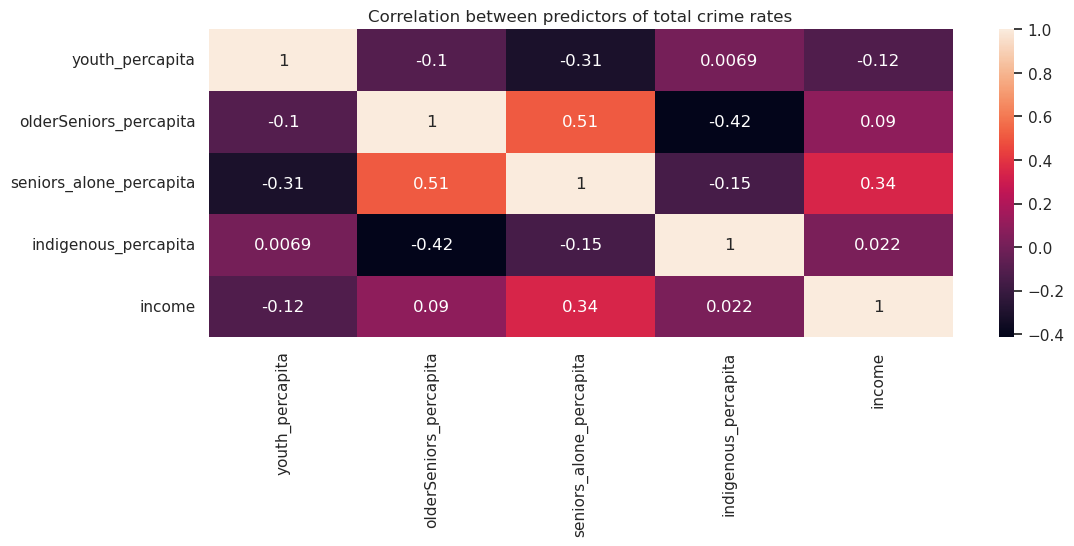

In [58]:
cormat = crime_regions[predictors_list_total].corr()
round(cormat,2)
ax = plt.axes()
sns.heatmap(cormat, annot=cormat)
ax.set_title('Correlation between predictors of total crime rates')
plt.show()

In [59]:
# multiple linear regression with selected predictors for violent crime rates
predictors_list_violence = []
for x in idx_violence:
    predictors_list_violence.append(predictors[x])

x_violence = crime_regions[predictors_list_violence]
x_violence = sm.add_constant(x_violence)
    
model = sm.OLS(y_violence, x_violence).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ViolenceCrimes_Rate2016   R-squared:                       0.686
Model:                                 OLS   Adj. R-squared:                  0.673
Method:                      Least Squares   F-statistic:                     56.67
Date:                     Wed, 07 Dec 2022   Prob (F-statistic):           5.15e-31
Time:                             03:53:56   Log-Likelihood:                -928.12
No. Observations:                      136   AIC:                             1868.
Df Residuals:                          130   BIC:                             1886.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.266e+04   1197.836     10.571      0.000    1.03e+04     1.5e+04
youth_percapita             0.0078      0.001      9.558      0.000       0.006       0.009
olderSeniors_percapita     -0.0198      0.002     -9.938      0.000      -0.024      -0.016
seniors_alone_percapita     0.0093      0.002      5.309      0.000       0.006       0.013
indigenous_percapita       -0.0129      0.001    -10.822      0.000      -0.015      -0.011
income                     -0.0030      0.001     -5.602      0.000      -0.004      -0.002
==============================================================================
Omnibus:                        7.727   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.696
Skew:                           0.579   Prob(JB):                       0.0213
Kurtosis:                       3.124   Cond. No.                     6.11e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

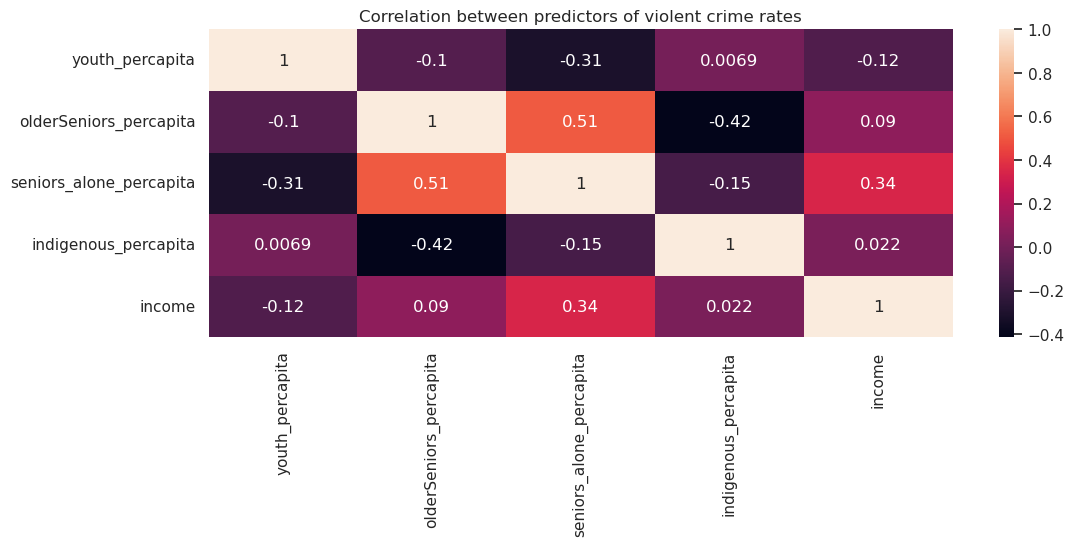

In [60]:
cormat = crime_regions[predictors_list_violence].corr()
round(cormat,2)
ax = plt.axes()
sns.heatmap(cormat, annot=cormat)
ax.set_title('Correlation between predictors of violent crime rates')
plt.show()

In [61]:
# multiple linear regression with selected predictors for property crime rates
predictors_list_property = []
for x in idx_property:
    predictors_list_property.append(predictors[x])

x_property = crime_regions[predictors_list_property]
x_property = sm.add_constant(x_property)
    
model1 = sm.OLS(y_property, x_property).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     PropertyCrimes_Rate2016   R-squared:                       0.335
Model:                                 OLS   Adj. R-squared:                  0.309
Method:                      Least Squares   F-statistic:                     13.09
Date:                     Wed, 07 Dec 2022   Prob (F-statistic):           2.54e-10
Time:                             03:53:58   Log-Likelihood:                -910.28
No. Observations:                      136   AIC:                             1833.
Df Residuals:                          130   BIC:                             1850.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    8990.8296   1188.308      7.566      0.000    6639.904    1.13e+04
children_percapita         -0.0043      0.001     -4.924      0.000      -0.006      -0.003
workingAge_percapita       -0.0037      0.001     -5.385      0.000      -0.005      -0.002
preRetirement_percapita    -0.0022      0.001     -1.731      0.086      -0.005       0.000
seniors_percapita          -0.0052      0.001     -6.038      0.000      -0.007      -0.003
indigenous_percapita       -0.0052      0.001     -4.840      0.000      -0.007      -0.003
==============================================================================
Omnibus:                       62.257   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.923
Skew:                           1.602   Prob(JB):                     2.44e-59
Kurtosis:                       9.113   Cond. No.                     7.69e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

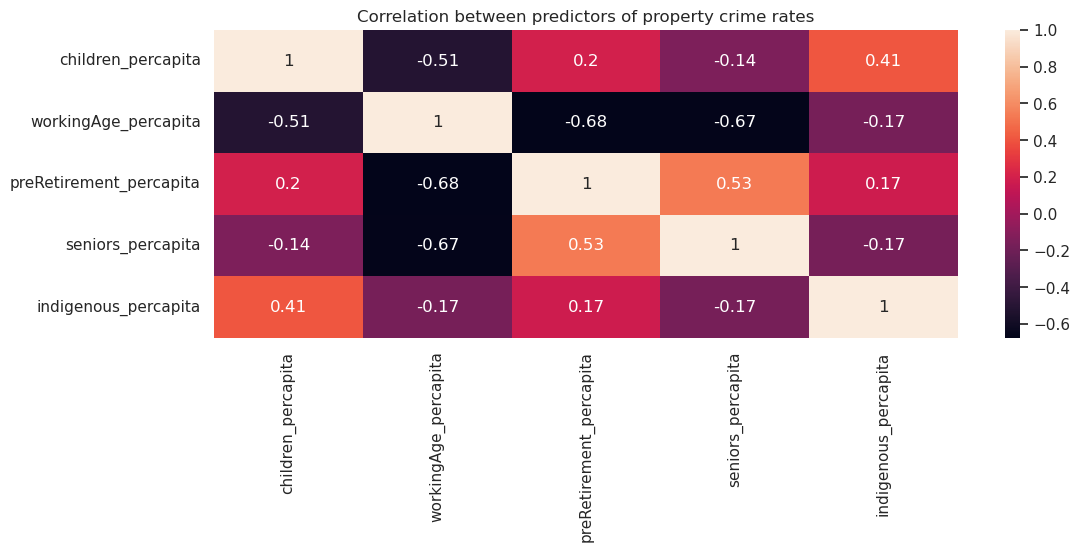

In [62]:
cormat = crime_regions[predictors_list_property].corr()
round(cormat,2)
ax = plt.axes()
sns.heatmap(cormat, annot=cormat)
ax.set_title('Correlation between predictors of property crime rates')
plt.show()

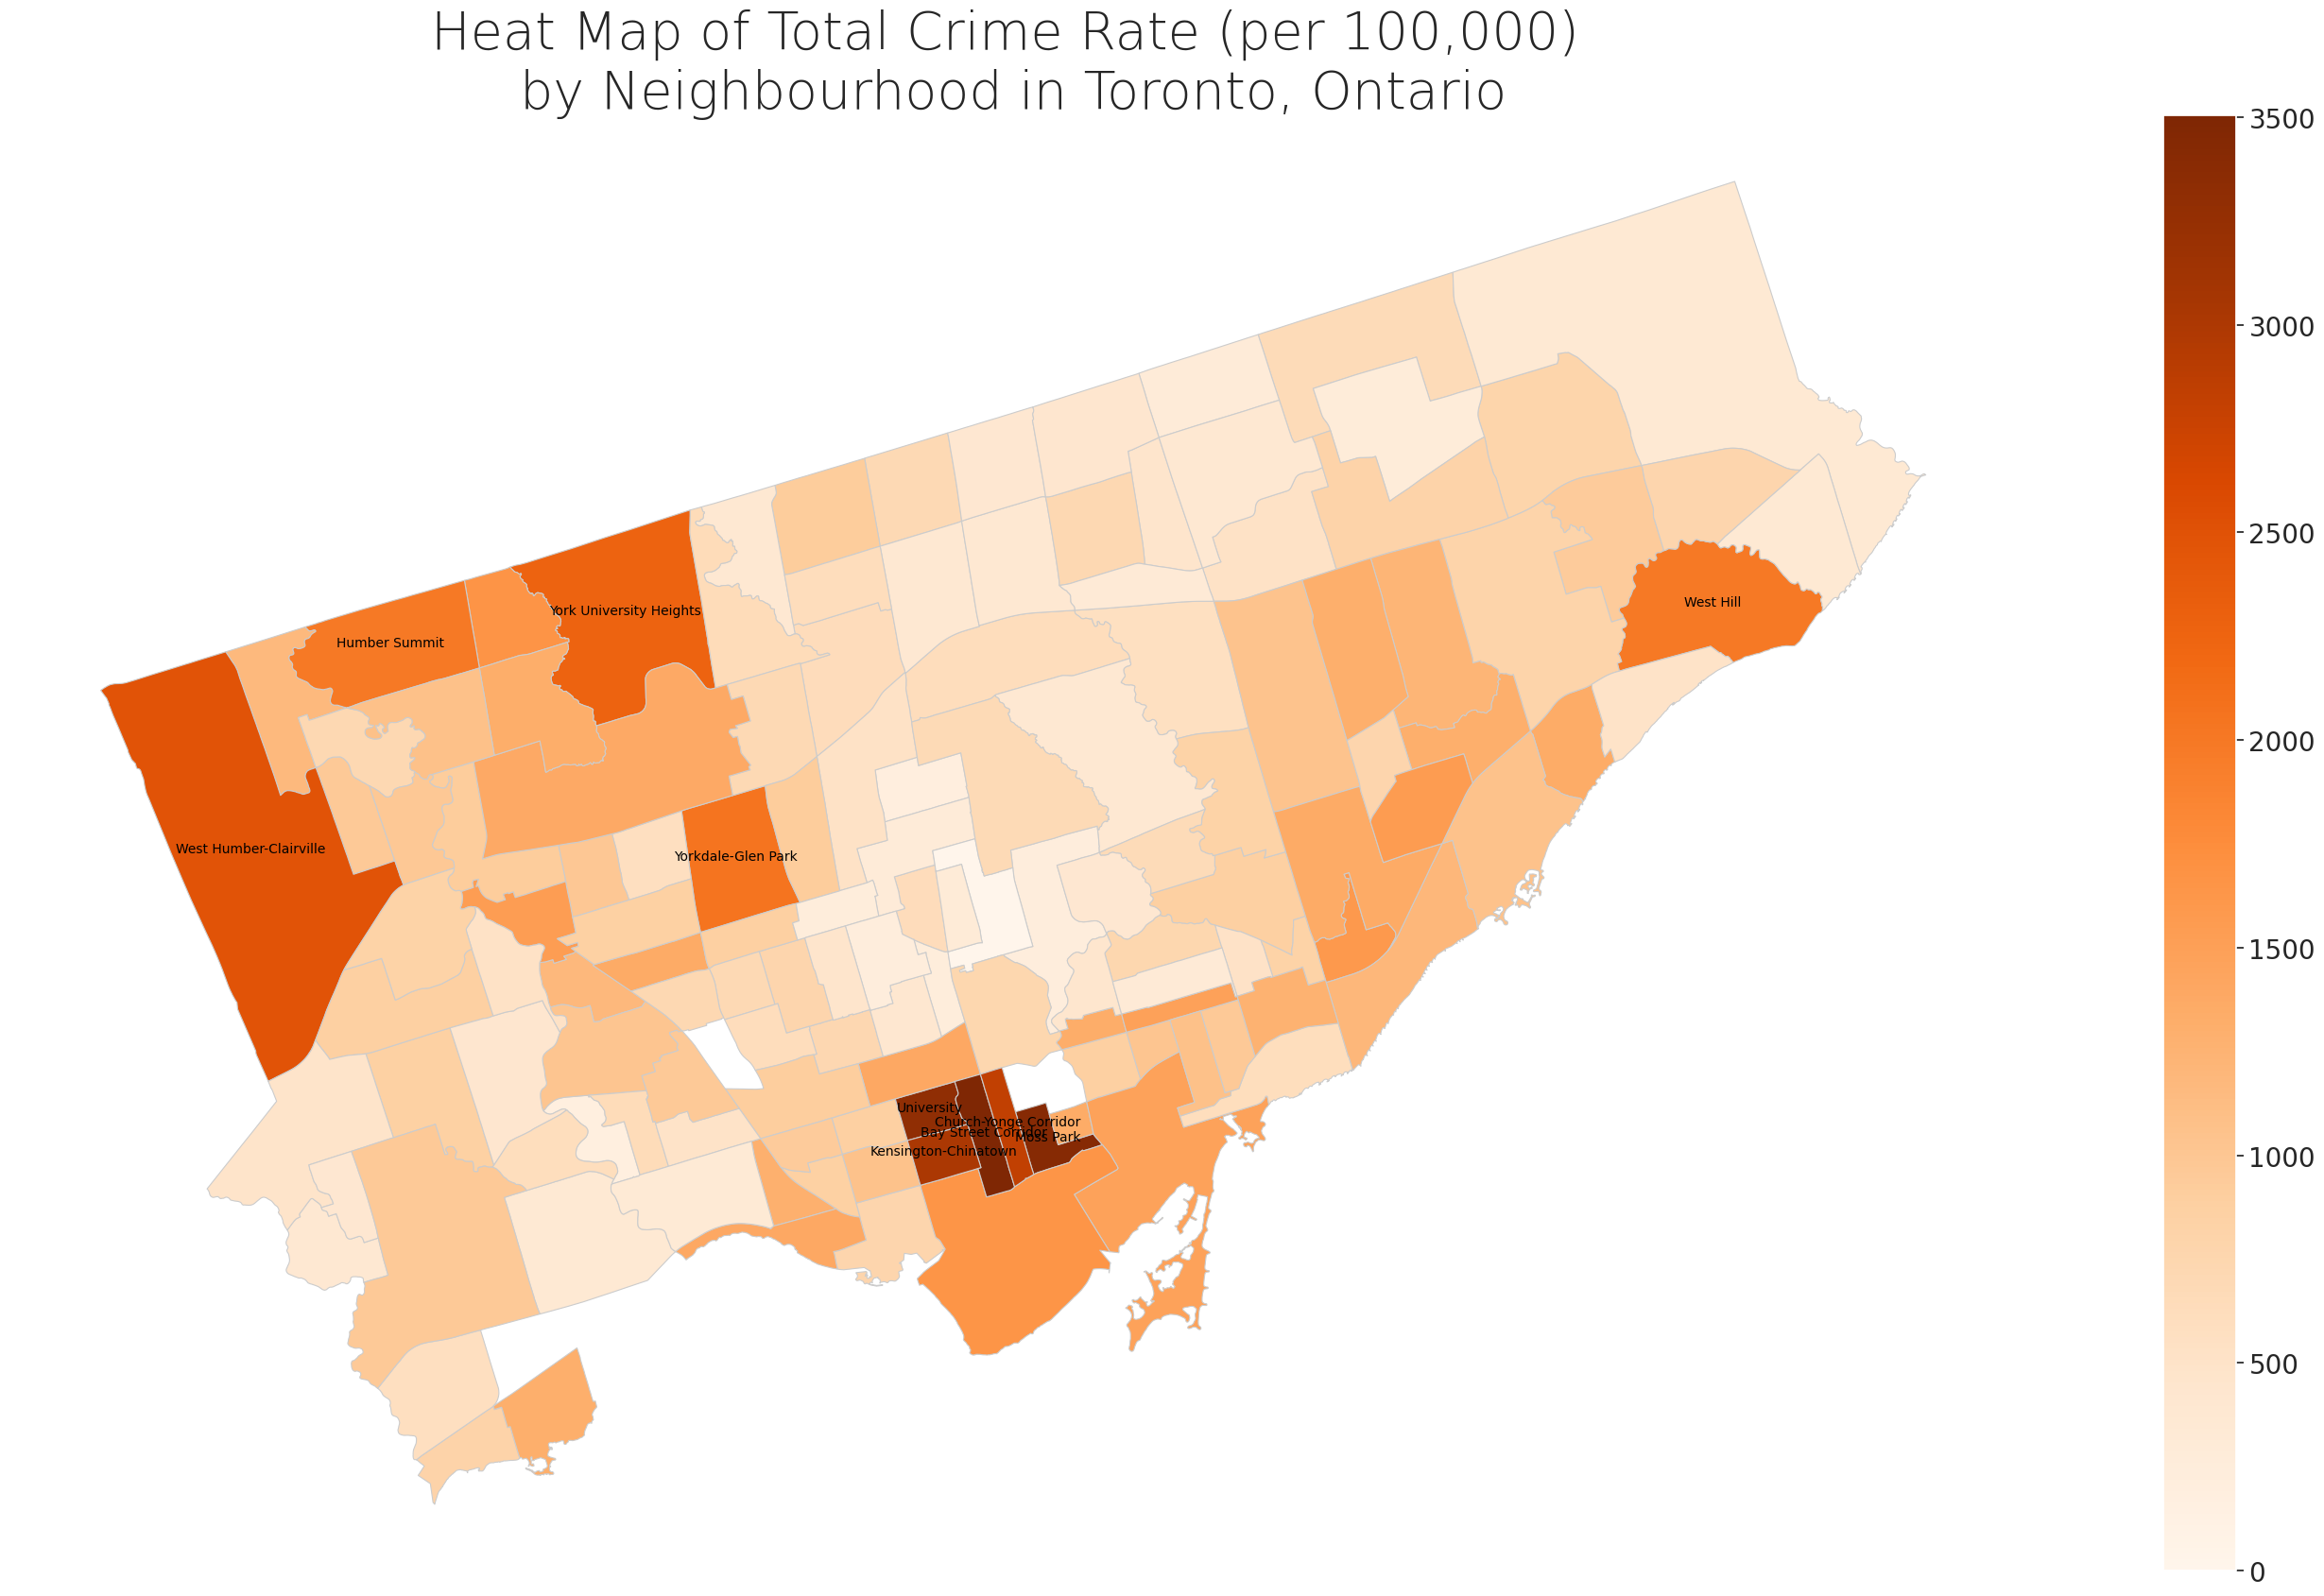

In [63]:
%%capture --no-display
# Heat Map of Total Crime Rate by Neighbourhood in Toronto
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Total Crime Rate (per 100,000) \nby Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 0, crime_regions['TotalCrimes_Rate2016'].max()
scaler_mappable = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#scaler_mappable._A = []
cbar = fig.colorbar(scaler_mappable)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('TotalCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['TotalCrimes_Rate2016'] > 2000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize=10, color='black', wrap=True)
plt.show()

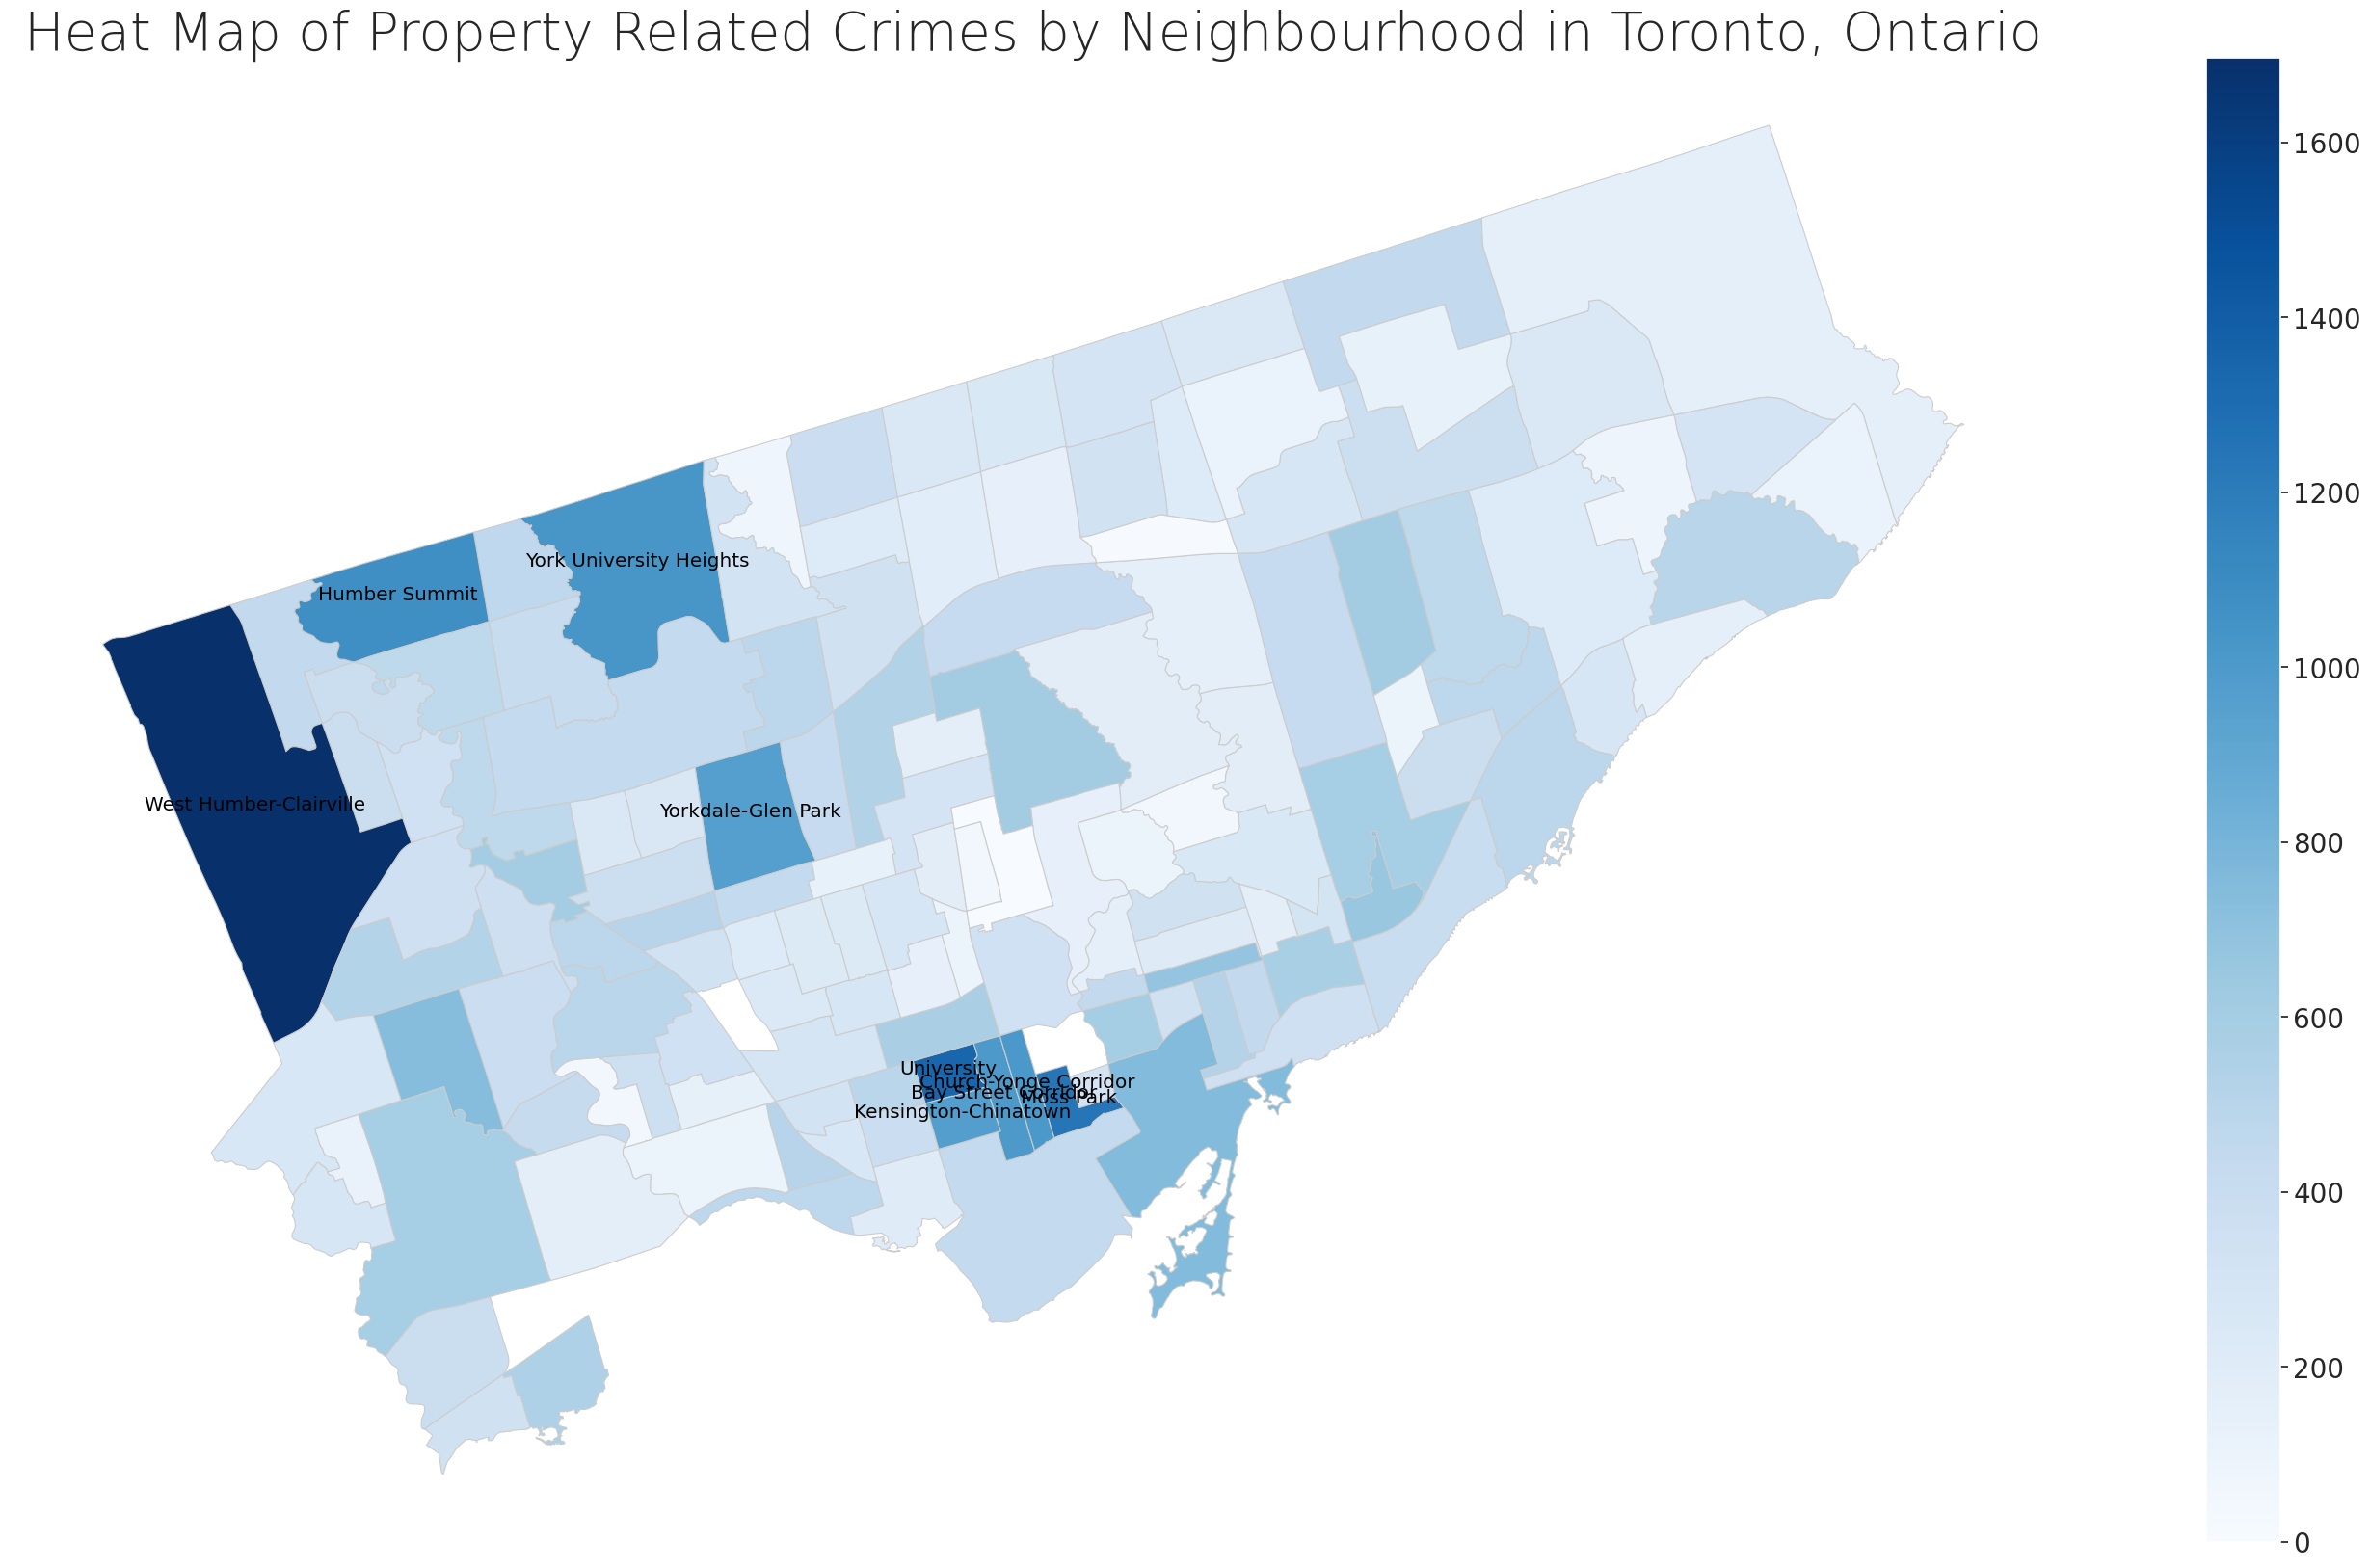

In [64]:
%%capture --no-display
# Heat Map of Property Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Property Related Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, crime_regions['PropertyCrimes_Rate2016'].max()
scaler_mappable = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#sm._A = []
cbar = fig.colorbar(scaler_mappable)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('PropertyCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['PropertyCrimes_Rate2016'] > 1000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

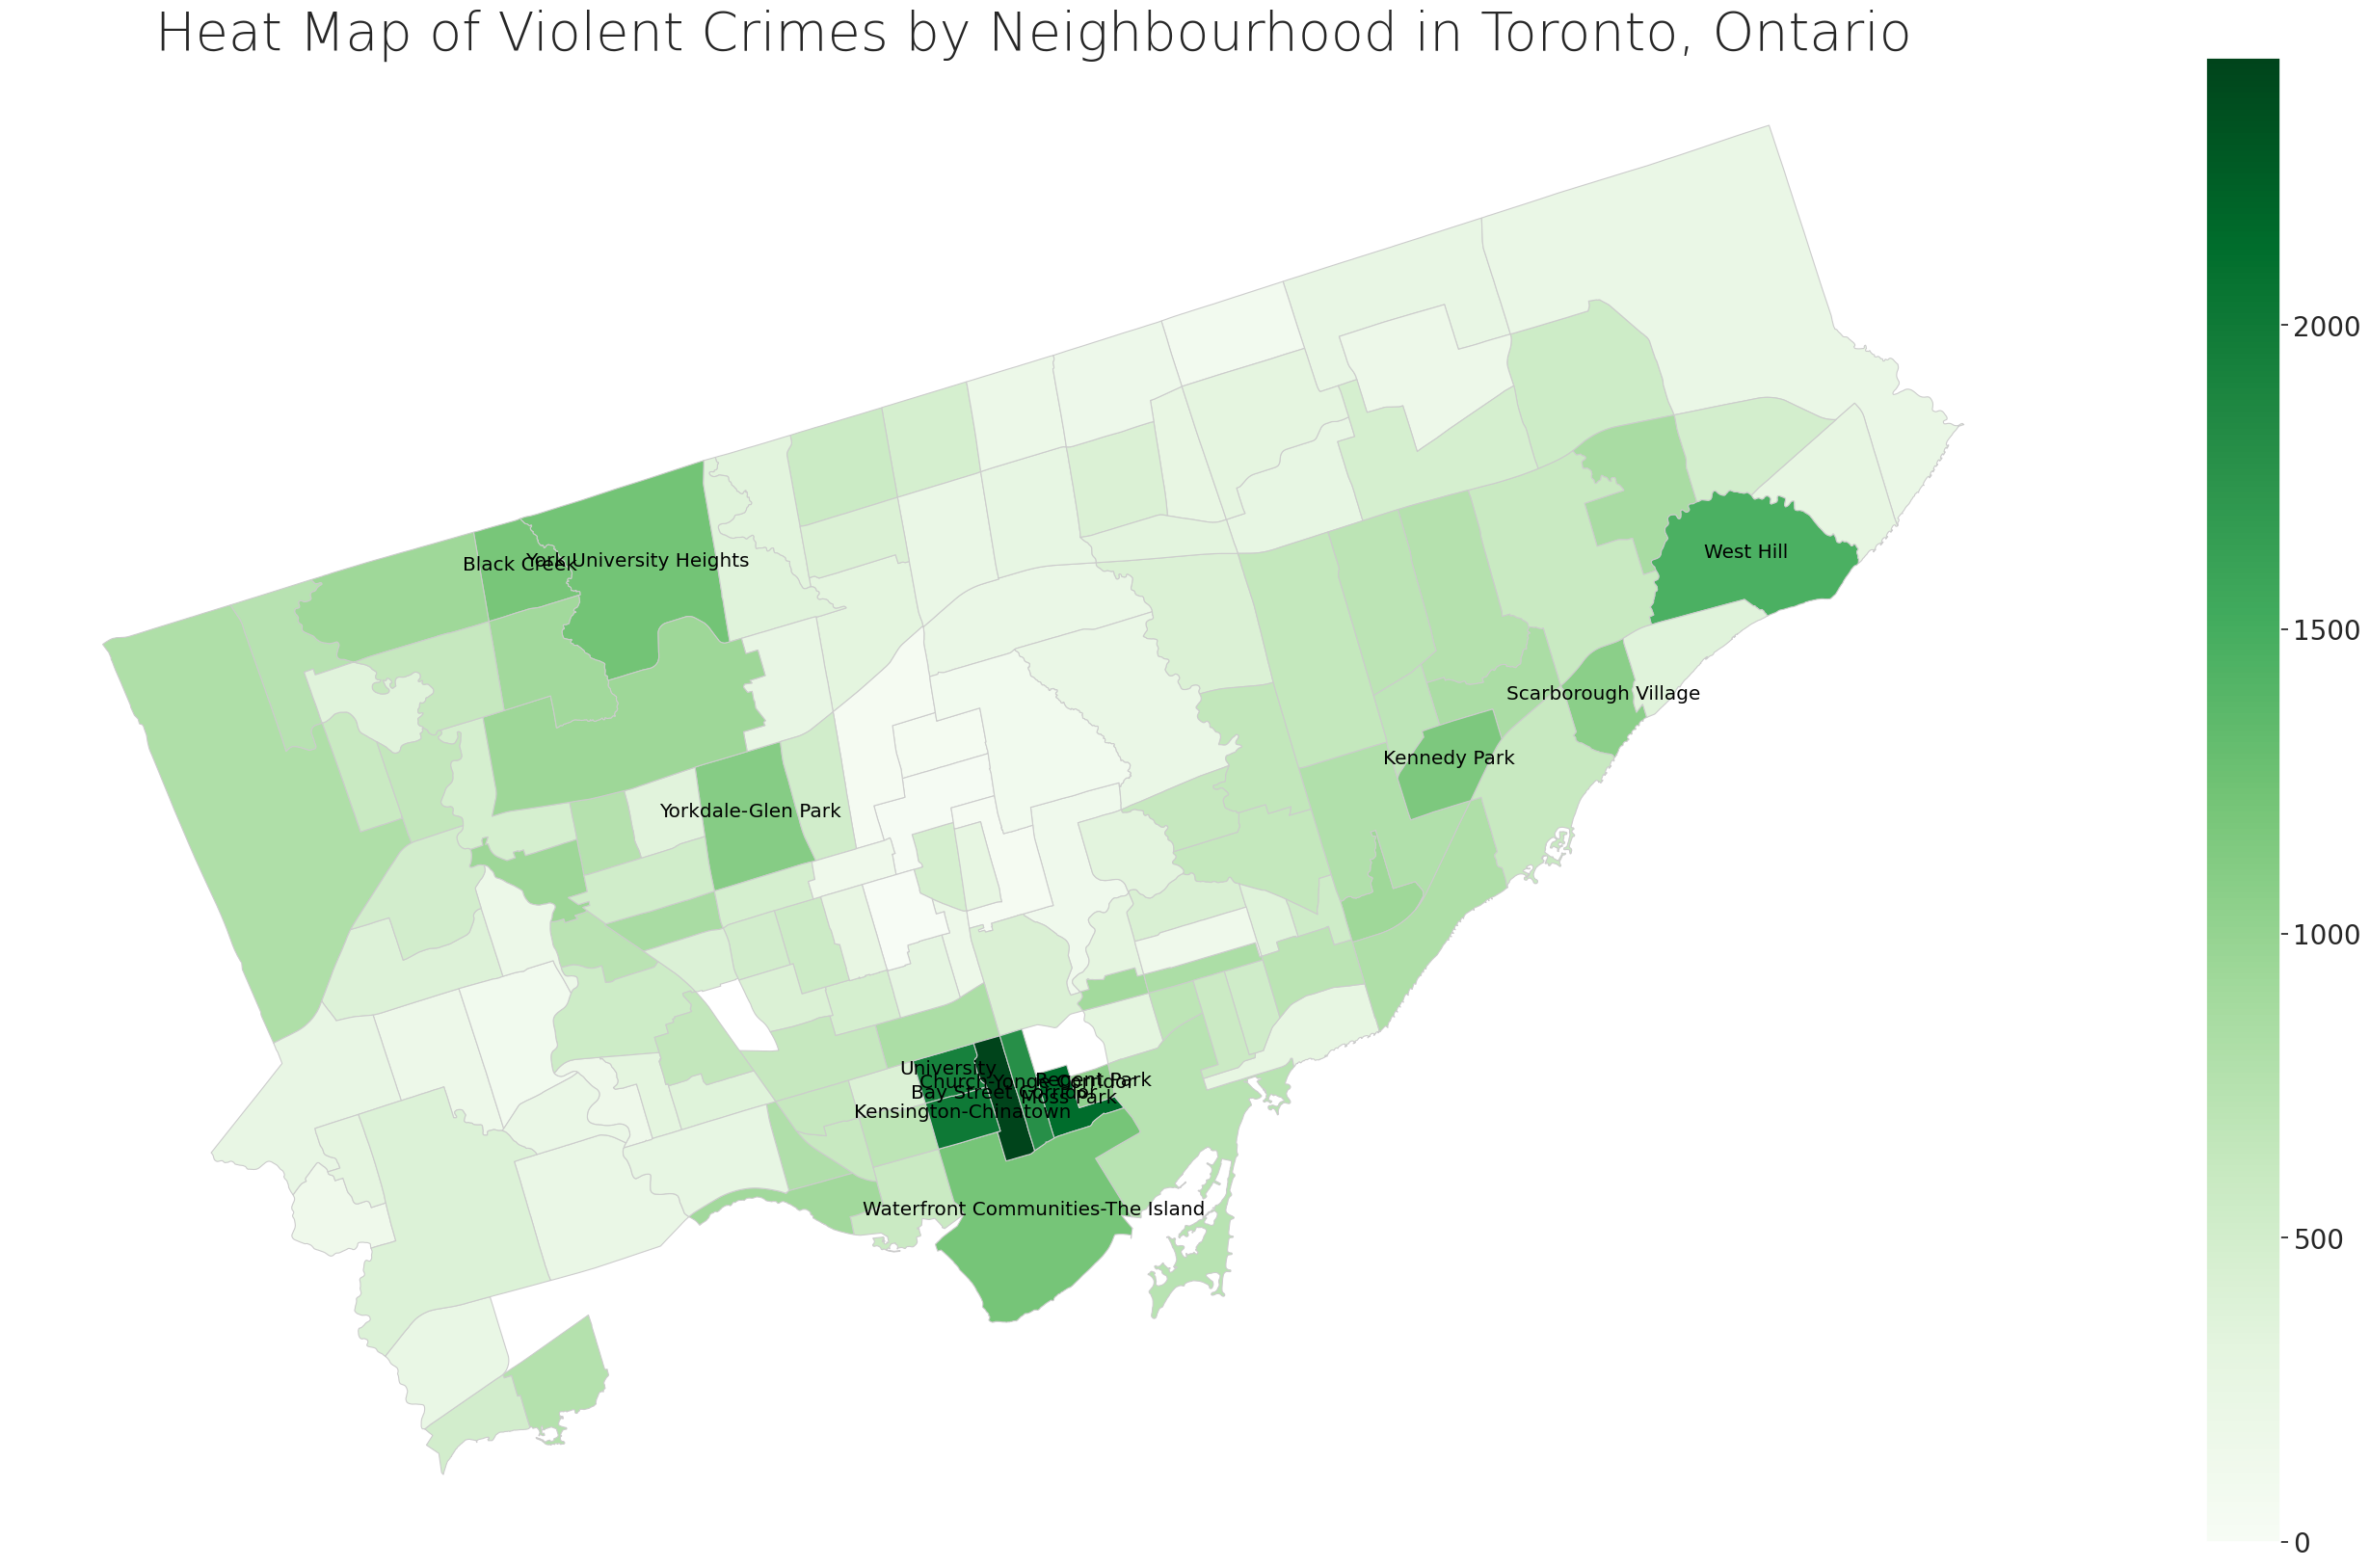

In [65]:
%%capture --no-display
# Heat Map of Violence Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Violent Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Greens'
vmin, vmax = 0, crime_regions['ViolenceCrimes_Rate2016'].max()
scaler_mappable = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#sm._A = []
cbar = fig.colorbar(scaler_mappable)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('ViolenceCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['ViolenceCrimes_Rate2016'] > 1000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

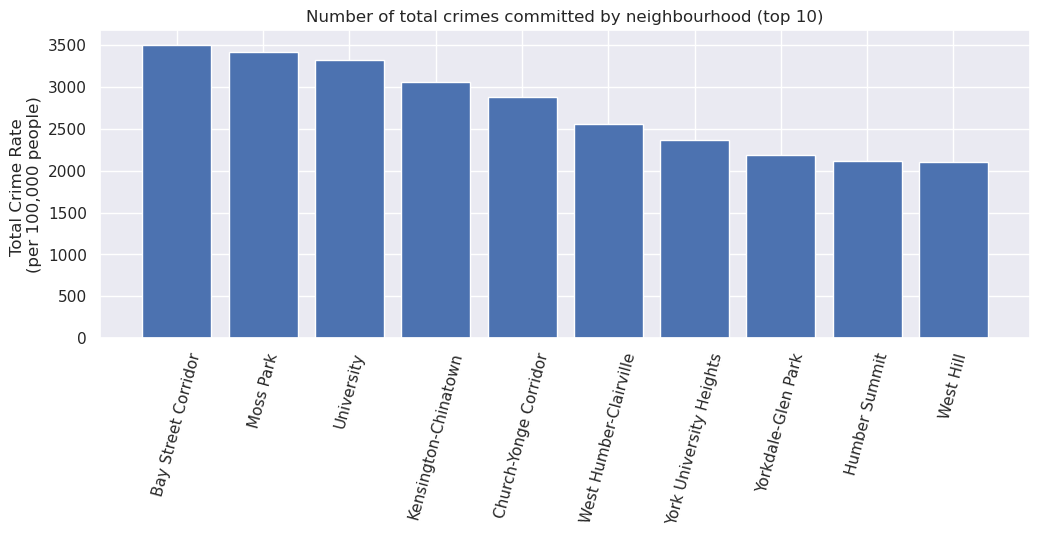

In [66]:
# assaults top 10 bar graph
crime_regions = crime_regions.sort_values(['TotalCrimes_Rate2016'], ascending=False)

fig, ax = plt.subplots()

ax.bar(crime_regions['neighbourhood'].iloc[:10], crime_regions['TotalCrimes_Rate2016'].iloc[:10])

ax.set_ylabel('Total Crime Rate \n(per 100,000 people)')
ax.set_title('Number of total crimes committed by neighbourhood (top 10)')
plt.xticks(rotation=75)

plt.show()

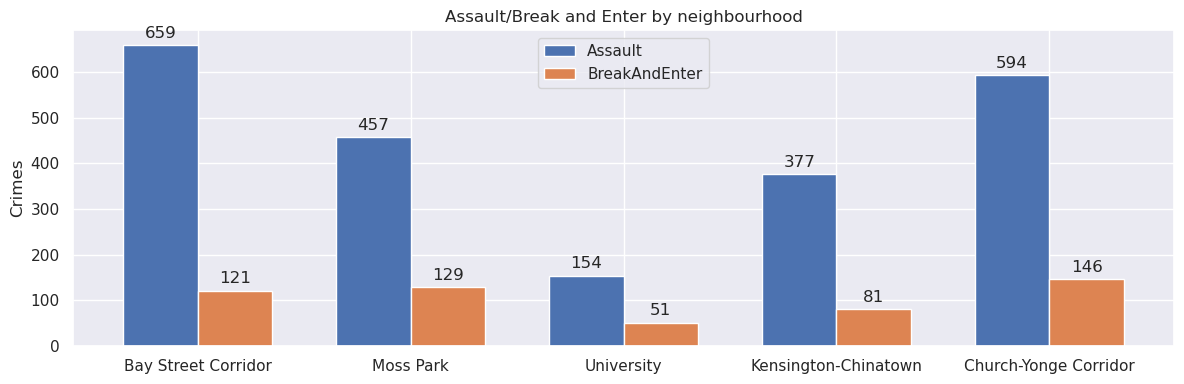

In [67]:
plt.rc('figure', figsize=(12, 4))

x = np.arange(len(crime_regions['neighbourhood'].iloc[:5]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

#rects1 = ax.bar(x - width/2, men_means, width, label='Men')
assault = ax.bar(x - width/2, crime_regions['Assault_2016'].iloc[:5], width, label='Assault')
homicide = ax.bar(x + width/2, crime_regions['BreakAndEnter_2016'].iloc[:5], width, label='BreakAndEnter')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crimes')
ax.set_title('Assault/Break and Enter by neighbourhood')
ax.set_xticks(x, crime_regions['neighbourhood'].iloc[:5])
ax.legend()

ax.bar_label(assault, padding=3)
ax.bar_label(homicide, padding=3)

fig.tight_layout()

plt.show()

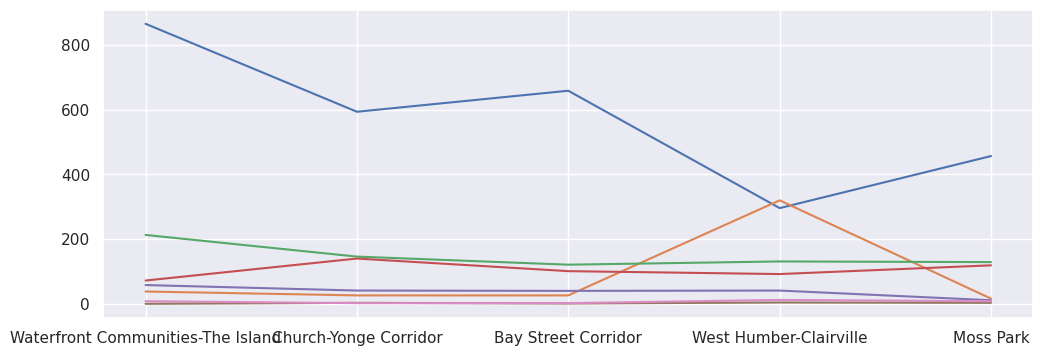

In [68]:
crime_regions = crime_regions.sort_values(['TotalCrimes_2016'], ascending=False)

plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Assault_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['AutoTheft_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['BreakAndEnter_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Robbery_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['TheftOver_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Homicide_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Shootings_2016'].iloc[:5])


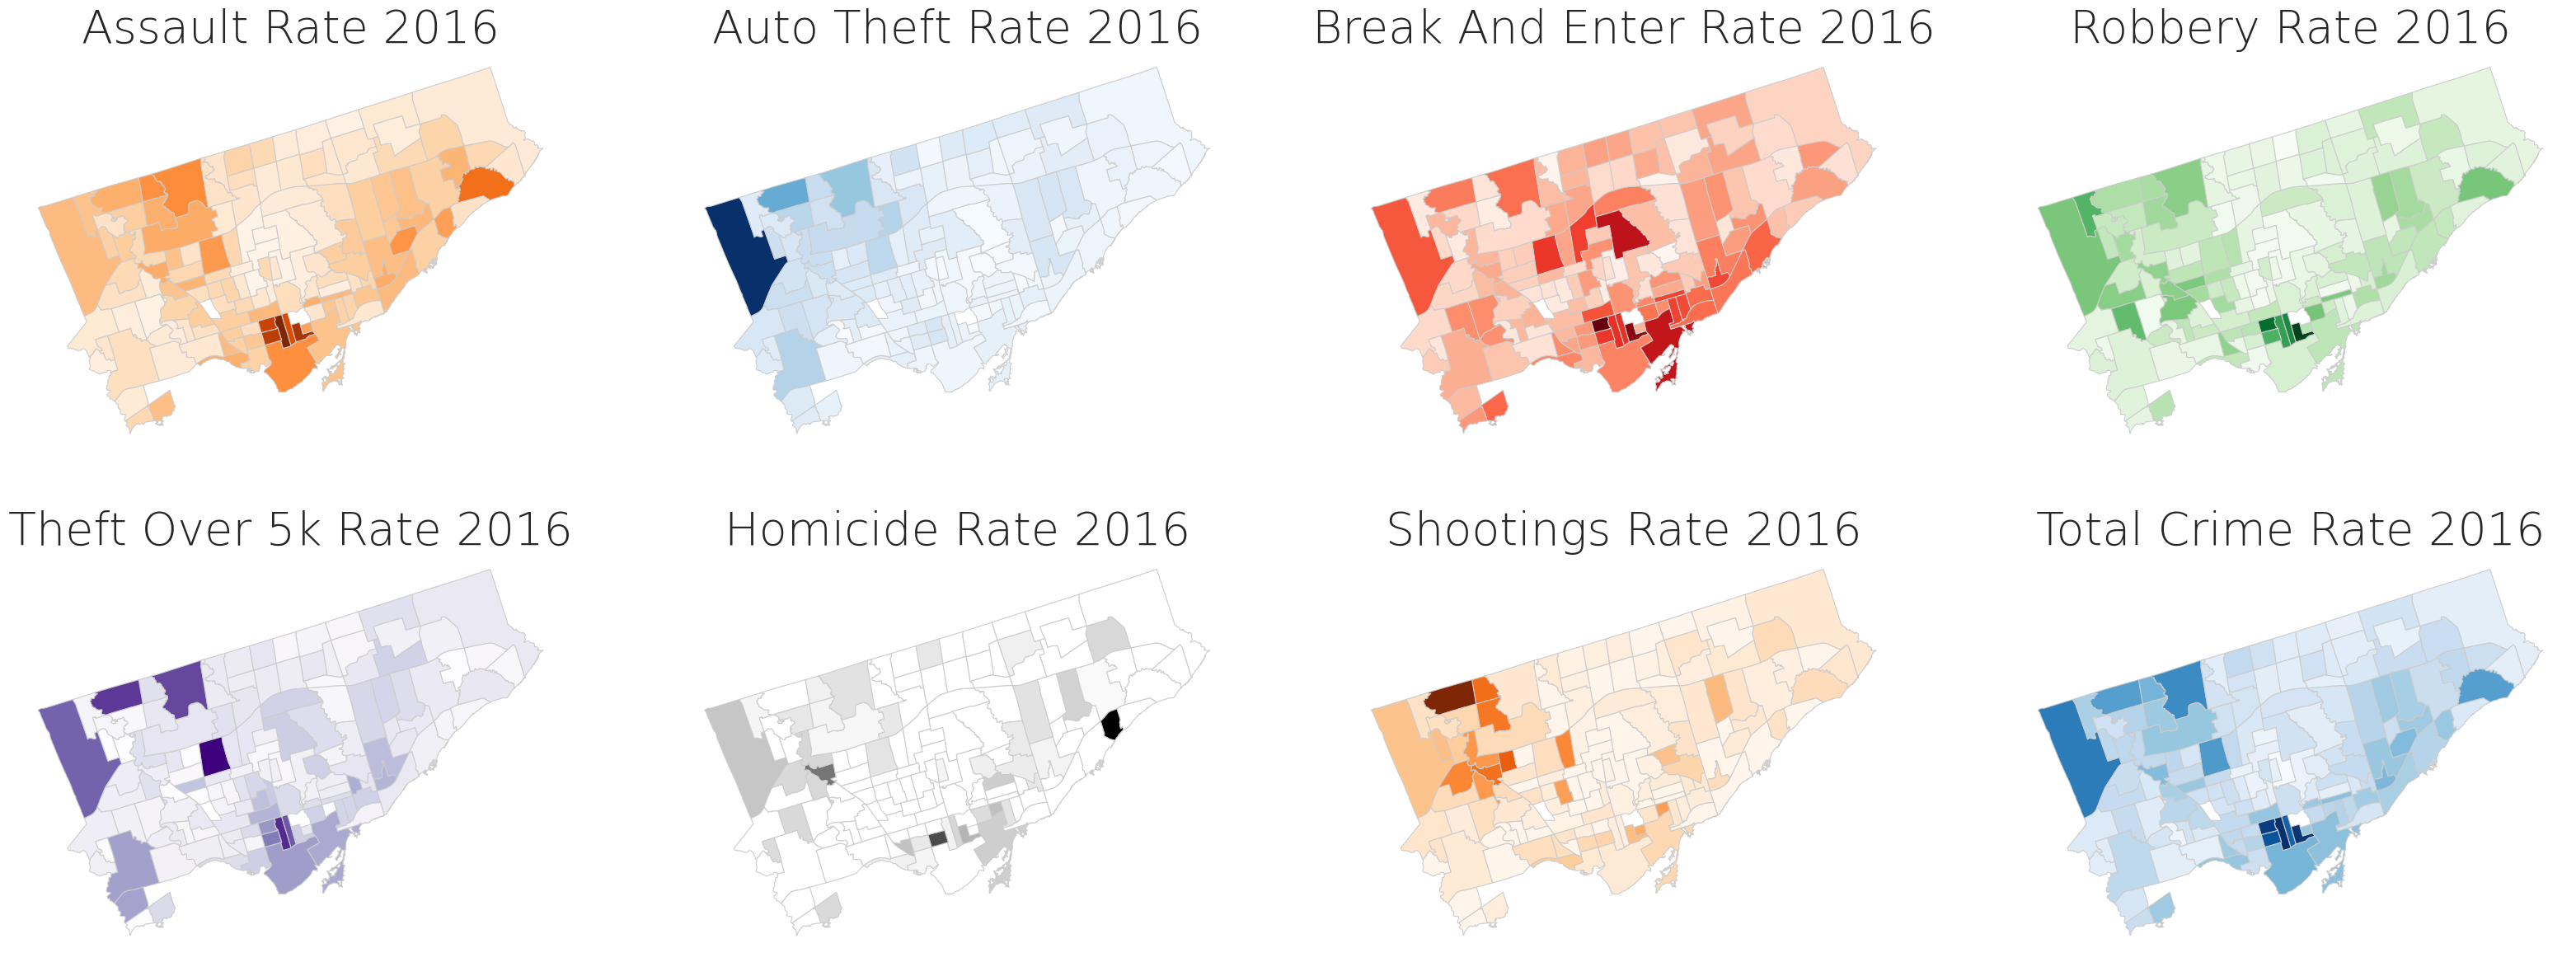

In [79]:
%%capture --no-display
# make smaller plots so we can visually compare them
crimes_of_interest_column_names = ["Assault_Rate2016", "AutoTheft_Rate2016", "BreakAndEnter_Rate2016", 
                                   "Robbery_Rate2016", "TheftOver_Rate2016", "Homicide_Rate2016", "Shootings_Rate2016", "TotalCrimes_Rate2016"]
# ensure this matches with the column names
crimes_of_interest_plot_titles = ["Assault Rate 2016", "Auto Theft Rate 2016", "Break And Enter Rate 2016", 
                                  "Robbery Rate 2016", "Theft Over 5k Rate 2016", "Homicide Rate 2016", "Shootings Rate 2016", "Total Crime Rate 2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens", "Purples", "Greys"]

fig_width = 10
fig_height = fig_width * 1.45

# make the plots
#fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(fig_width * 4, fig_height))

for i in range(0, 2):
    for j in range(0,4):
        index = i * 4 + j        
        if (index > len(crimes_of_interest_column_names)):
            break
            
        axs[i, j].axis("off")
        
        crime_column = crimes_of_interest_column_names[index]
        crime_name = crimes_of_interest_plot_titles[index]
                  
        axs[i, j].set_title(f"{crime_name}", fontdict={'fontsize': '40', 'fontweight' : '5'})

        color = colors[index % len(colors)]
        vmin, vmax = 0, crime_regions[crime_column].max()
        scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)

        #cbar = fig.colorbar(scalar_mappable)
        #cbar.ax.tick_params(labelsize=14)

        crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i, j], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()

In [71]:
    
#####################
discard = '''
# make the plot
fig, ax = plt.subplots(1, figsize=(10,5))
ax.axis('off')
ax.set_title('Heat Map of Unemployment', fontdict={'fontsize': '10', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

merged.plot('Assault_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(10,5))

plt.show()
'''

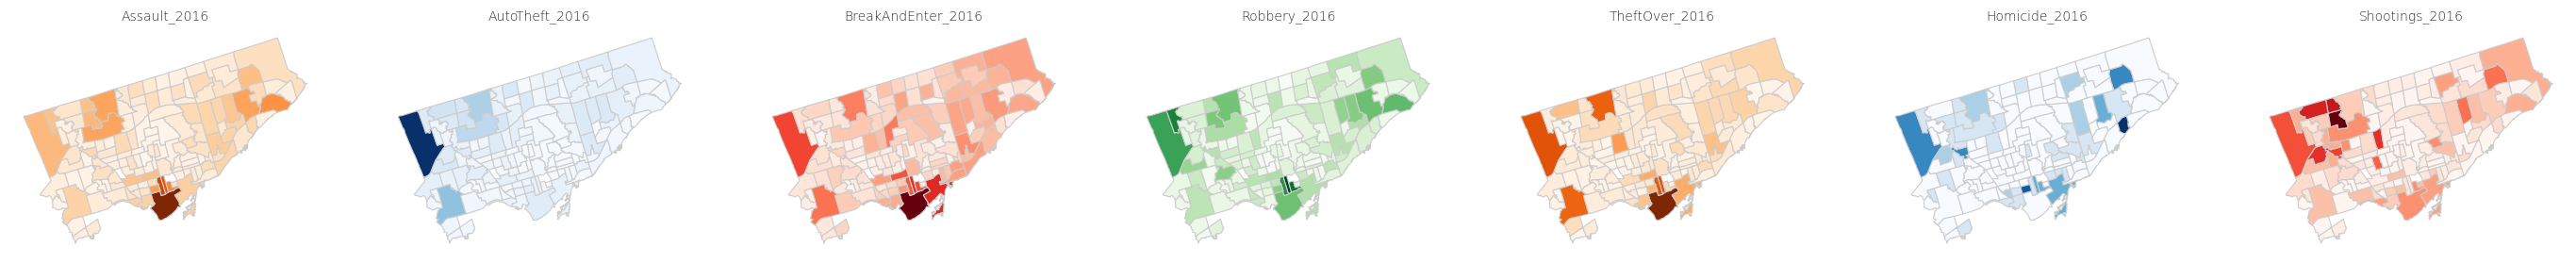

In [72]:
%%capture --no-display
# compare distribution of features compared to outcomes

crimes_of_interest_column_names = ["Assault_2016", "AutoTheft_2016", "BreakAndEnter_2016", "Robbery_2016", "TheftOver_2016", "Homicide_2016", "Shootings_2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens"]

fig_width = 5
fig_height = 5

# make the plots
fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
# common settings for all plots:
for ax in axs:
    ax.axis('off')

# unique settings:
for i in range(0, len(crimes_of_interest_column_names)):
    crime_column = crimes_of_interest_column_names[i]
    #todo: fix title crime name
    axs[i].set_title(f"{crime_column}", fontdict={'fontsize': '10', 'fontweight' : '3'})

    color = colors[i % len(colors)]
    vmin, vmax = 0, crime_regions[crime_column].max()
    scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)
    
    #cbar = fig.colorbar(scalar_mappable)
    #cbar.ax.tick_params(labelsize=14)

    crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()
    

In [73]:
# Unpivot the crime dataframe
crime_years = pd.melt(crime_raw, id_vars=['OBJECTID','Neighbourhood','Hood_ID','F2020_Population_Projection','Shape__Area','Shape__Length'])


In [74]:
# adjust the variable column to split
crime_years['variable'] = crime_years['variable'].str.replace('_Rate', 'Rate_')


In [75]:
# split variable column into crime_type and year
crime_years[['crime_type','year']] = crime_years['variable'].str.split('_', expand=True)


In [76]:
# remove columns that are not used
crime_years = crime_years.drop('OBJECTID', axis=1)
crime_years = crime_years.drop('Hood_ID', axis=1)
crime_years = crime_years.drop('F2020_Population_Projection', axis=1)
crime_years = crime_years.drop('Shape__Area', axis=1)
crime_years = crime_years.drop('Shape__Length', axis=1)
crime_years = crime_years.drop('variable', axis=1)


In [77]:
crime_years

,Neighbourhood,value,crime_type,year
0,Yonge-St.Clair,16.000000,Assault,2014
1,York University Heights,273.000000,Assault,2014
2,Lansing-Westgate,42.000000,Assault,2014
3,Yorkdale-Glen Park,106.000000,Assault,2014
4,Stonegate-Queensway,91.000000,Assault,2014
...,...,...,...,...
13715,Pleasant View,1.186521,ShootingsRate,2020
13716,Wychwood,1.247116,ShootingsRate,2020
13717,Leaside-Bennington,0.000000,ShootingsRate,2020
13718,Briar Hill-Belgravia,0.647333,ShootingsRate,2020
